In [9]:
import pandas as pd
import konlpy
import gensim

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [10]:
duplicates = train_data.duplicated()
duplicates.any()

False

In [11]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

'''
1. 데이터의 중복 제거
2. NaN 결측치 제거
3. 한국어 토크나이저로 토큰화
4. 불용어(Stopwords) 제거
5. 사전word_to_index 구성
6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
7. X_train, y_train, X_test, y_test, word_to_index 리턴

'''

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)  #1
    train_data = train_data.dropna()  #2
    test_data.drop_duplicates(subset=['document'], inplace=True)  #1
    test_data = test_data.dropna()  #2
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 3
        temp_X = [word for word in temp_X if not word in stopwords] # 4
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 3
        temp_X = [word for word in temp_X if not word in stopwords] # 4
        X_test.append(temp_X)
        
    words = np.concatenate(X_train).tolist() 
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)} #5
    
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist] #6
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index #7
        
    
    

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [12]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [13]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [14]:
total_data = X_train + X_test

num_tokens = [len(tokens) for tokens in total_data]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [15]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)

In [16]:
import tensorflow as tf

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=0,
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=0,
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [17]:
# validation set 25000건 분리
X_val = X_train[:25000]   
y_val = y_train[:25000]

# validation set을 제외한 나머지 25000건
partial_X_train = X_train[25000:]  
partial_y_train = y_train[25000:]

In [18]:
vocab_size = 10000
word_vector_dim = 41

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 41)          410000    
_________________________________________________________________
global_max_pooling1d (Global (None, 41)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 336       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 410,345
Trainable params: 410,345
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)



Epoch 1/20
237/237 [==============================] - 2s 5ms/step - loss: 0.5378 - accuracy: 0.7829 - val_loss: 0.3828 - val_accuracy: 0.8336
Epoch 2/20
237/237 [==============================] - 1s 4ms/step - loss: 0.3466 - accuracy: 0.8518 - val_loss: 0.3462 - val_accuracy: 0.8481
Epoch 3/20
237/237 [==============================] - 1s 4ms/step - loss: 0.3014 - accuracy: 0.8736 - val_loss: 0.3423 - val_accuracy: 0.8506
Epoch 4/20
237/237 [==============================] - 1s 4ms/step - loss: 0.2718 - accuracy: 0.8891 - val_loss: 0.3460 - val_accuracy: 0.8515
Epoch 5/20
237/237 [==============================] - 1s 4ms/step - loss: 0.2473 - accuracy: 0.9009 - val_loss: 0.3555 - val_accuracy: 0.8504
Epoch 6/20
237/237 [==============================] - 1s 4ms/step - loss: 0.2255 - accuracy: 0.9113 - val_loss: 0.3680 - val_accuracy: 0.8498
Epoch 7/20
237/237 [==============================] - 1s 4ms/step - loss: 0.2052 - accuracy: 0.9218 - val_loss: 0.3832 - val_accuracy: 0.8495
Epoch 

In [20]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.7435 - accuracy: 0.8182
[0.7435395121574402, 0.818235456943512]


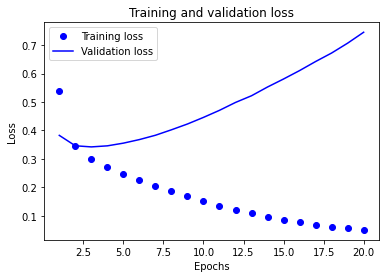

In [21]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [22]:
# model2 = epoch 조절해서 다시 

model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=3,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/3
237/237 [==============================] - 2s 4ms/step - loss: 0.5236 - accuracy: 0.7823 - val_loss: 0.3774 - val_accuracy: 0.8350
Epoch 2/3
237/237 [==============================] - 1s 4ms/step - loss: 0.3420 - accuracy: 0.8538 - val_loss: 0.3440 - val_accuracy: 0.8482
Epoch 3/3
237/237 [==============================] - 1s 4ms/step - loss: 0.2975 - accuracy: 0.8755 - val_loss: 0.3416 - val_accuracy: 0.8525
1537/1537 - 2s - loss: 0.3513 - accuracy: 0.8475
[0.3513391613960266, 0.8475293517112732]


Epoch 1/20
237/237 [==============================] - 5s 8ms/step - loss: 0.4814 - accuracy: 0.7882 - val_loss: 0.3584 - val_accuracy: 0.8484
Epoch 2/20
237/237 [==============================] - 1s 6ms/step - loss: 0.3317 - accuracy: 0.8609 - val_loss: 0.3426 - val_accuracy: 0.8514
Epoch 3/20
237/237 [==============================] - 1s 6ms/step - loss: 0.3046 - accuracy: 0.8736 - val_loss: 0.3423 - val_accuracy: 0.8539
Epoch 4/20
237/237 [==============================] - 1s 6ms/step - loss: 0.2878 - accuracy: 0.8808 - val_loss: 0.3458 - val_accuracy: 0.8530
Epoch 5/20
237/237 [==============================] - 1s 6ms/step - loss: 0.2720 - accuracy: 0.8884 - val_loss: 0.3534 - val_accuracy: 0.8524
Epoch 6/20
237/237 [==============================] - 2s 6ms/step - loss: 0.2587 - accuracy: 0.8946 - val_loss: 0.3567 - val_accuracy: 0.8496
Epoch 7/20
237/237 [==============================] - 1s 6ms/step - loss: 0.2468 - accuracy: 0.9002 - val_loss: 0.3735 - val_accuracy: 0.8482
Epoch 

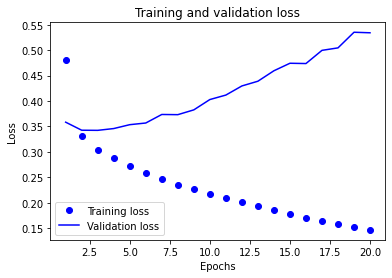

In [23]:
# model3 LSTM 사용


model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [24]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=9 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)


Epoch 1/9
237/237 [==============================] - 3s 8ms/step - loss: 0.4901 - accuracy: 0.7933 - val_loss: 0.3704 - val_accuracy: 0.8450
Epoch 2/9
237/237 [==============================] - 1s 6ms/step - loss: 0.3426 - accuracy: 0.8586 - val_loss: 0.3541 - val_accuracy: 0.8489
Epoch 3/9
237/237 [==============================] - 1s 6ms/step - loss: 0.3179 - accuracy: 0.8705 - val_loss: 0.3554 - val_accuracy: 0.8492
Epoch 4/9
237/237 [==============================] - 1s 6ms/step - loss: 0.3026 - accuracy: 0.8780 - val_loss: 0.3546 - val_accuracy: 0.8490
Epoch 5/9
237/237 [==============================] - 1s 6ms/step - loss: 0.2899 - accuracy: 0.8836 - val_loss: 0.3544 - val_accuracy: 0.8510
Epoch 6/9
237/237 [==============================] - 1s 6ms/step - loss: 0.2776 - accuracy: 0.8893 - val_loss: 0.3556 - val_accuracy: 0.8520
Epoch 7/9
237/237 [==============================] - 1s 6ms/step - loss: 0.2672 - accuracy: 0.8944 - val_loss: 0.3579 - val_accuracy: 0.8518
Epoch 8/9
237

In [25]:
# 차원수 수정

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(41))   
model.add(tf.keras.layers.Dense(41, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=9 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/9
237/237 [==============================] - 4s 8ms/step - loss: 0.4364 - accuracy: 0.7968 - val_loss: 0.3533 - val_accuracy: 0.8464
Epoch 2/9
237/237 [==============================] - 2s 6ms/step - loss: 0.3324 - accuracy: 0.8573 - val_loss: 0.3454 - val_accuracy: 0.8506
Epoch 3/9
237/237 [==============================] - 2s 6ms/step - loss: 0.3125 - accuracy: 0.8674 - val_loss: 0.3416 - val_accuracy: 0.8508
Epoch 4/9
237/237 [==============================] - 2s 6ms/step - loss: 0.2964 - accuracy: 0.8746 - val_loss: 0.3429 - val_accuracy: 0.8534
Epoch 5/9
237/237 [==============================] - 2s 6ms/step - loss: 0.2796 - accuracy: 0.8810 - val_loss: 0.3478 - val_accuracy: 0.8530
Epoch 6/9
237/237 [==============================] - 2s 6ms/step - loss: 0.2620 - accuracy: 0.8884 - val_loss: 0.3671 - val_accuracy: 0.8524
Epoch 7/9
237/237 [==============================] - 2s 6ms/step - loss: 0.2441 - accuracy: 0.8966 - val_loss: 0.3759 - val_accuracy: 0.8507
Epoch 8/9
237

In [26]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(41))   
model.add(tf.keras.layers.Dense(41, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=5

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/5
237/237 [==============================] - 3s 8ms/step - loss: 0.4353 - accuracy: 0.7951 - val_loss: 0.3503 - val_accuracy: 0.8490
Epoch 2/5
237/237 [==============================] - 2s 6ms/step - loss: 0.3312 - accuracy: 0.8594 - val_loss: 0.3489 - val_accuracy: 0.8488
Epoch 3/5
237/237 [==============================] - 2s 7ms/step - loss: 0.3128 - accuracy: 0.8680 - val_loss: 0.3469 - val_accuracy: 0.8498
Epoch 4/5
237/237 [==============================] - 2s 6ms/step - loss: 0.2965 - accuracy: 0.8756 - val_loss: 0.3440 - val_accuracy: 0.8491
Epoch 5/5
237/237 [==============================] - 2s 7ms/step - loss: 0.2755 - accuracy: 0.8841 - val_loss: 0.3406 - val_accuracy: 0.8544
1537/1537 - 3s - loss: 0.3489 - accuracy: 0.8479
[0.3489445447921753, 0.8478955030441284]


In [27]:
# Bidirection 층 with dropout
from tensorflow.keras.layers import Dropout, Bidirectional, LSTM, Embedding, Dense

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.5))
model.add(Dense(24, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=10

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/10
237/237 [==============================] - 10s 20ms/step - loss: 0.4429 - accuracy: 0.7889 - val_loss: 0.3469 - val_accuracy: 0.8473
Epoch 2/10
237/237 [==============================] - 3s 14ms/step - loss: 0.3324 - accuracy: 0.8595 - val_loss: 0.3513 - val_accuracy: 0.8448
Epoch 3/10
237/237 [==============================] - 3s 14ms/step - loss: 0.3098 - accuracy: 0.8685 - val_loss: 0.3483 - val_accuracy: 0.8508
Epoch 4/10
237/237 [==============================] - 3s 15ms/step - loss: 0.2925 - accuracy: 0.8758 - val_loss: 0.3447 - val_accuracy: 0.8514
Epoch 5/10
237/237 [==============================] - 3s 15ms/step - loss: 0.2759 - accuracy: 0.8834 - val_loss: 0.3599 - val_accuracy: 0.8497
Epoch 6/10
237/237 [==============================] - 3s 15ms/step - loss: 0.2587 - accuracy: 0.8909 - val_loss: 0.3746 - val_accuracy: 0.8485
Epoch 7/10
237/237 [==============================] - 3s 14ms/step - loss: 0.2416 - accuracy: 0.8979 - val_loss: 0.3928 - val_accuracy: 0.849

In [28]:
from tensorflow.keras.layers import Dropout, Bidirectional, LSTM, Embedding, Dense

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.5))
model.add(Dense(24, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=5

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/5
237/237 [==============================] - 10s 21ms/step - loss: 0.4498 - accuracy: 0.7835 - val_loss: 0.3512 - val_accuracy: 0.8460
Epoch 2/5
237/237 [==============================] - 3s 15ms/step - loss: 0.3368 - accuracy: 0.8586 - val_loss: 0.3467 - val_accuracy: 0.8502
Epoch 3/5
237/237 [==============================] - 3s 14ms/step - loss: 0.3140 - accuracy: 0.8687 - val_loss: 0.3412 - val_accuracy: 0.8507
Epoch 4/5
237/237 [==============================] - 3s 14ms/step - loss: 0.2912 - accuracy: 0.8790 - val_loss: 0.3483 - val_accuracy: 0.8498
Epoch 5/5
237/237 [==============================] - 3s 15ms/step - loss: 0.2696 - accuracy: 0.8864 - val_loss: 0.3658 - val_accuracy: 0.8498
1537/1537 - 7s - loss: 0.3664 - accuracy: 0.8474
[0.3664029836654663, 0.8474276065826416]


In [29]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(24, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=5

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/5
237/237 [==============================] - 10s 22ms/step - loss: 0.4292 - accuracy: 0.7946 - val_loss: 0.3542 - val_accuracy: 0.8444
Epoch 2/5
237/237 [==============================] - 4s 17ms/step - loss: 0.3313 - accuracy: 0.8591 - val_loss: 0.3429 - val_accuracy: 0.8479
Epoch 3/5
237/237 [==============================] - 4s 17ms/step - loss: 0.3065 - accuracy: 0.8703 - val_loss: 0.3401 - val_accuracy: 0.8516
Epoch 4/5
237/237 [==============================] - 4s 17ms/step - loss: 0.2837 - accuracy: 0.8787 - val_loss: 0.3490 - val_accuracy: 0.8538
Epoch 5/5
237/237 [==============================] - 4s 17ms/step - loss: 0.2650 - accuracy: 0.8880 - val_loss: 0.3499 - val_accuracy: 0.8511
1537/1537 - 7s - loss: 0.3571 - accuracy: 0.8467
[0.35710036754608154, 0.8466545939445496]


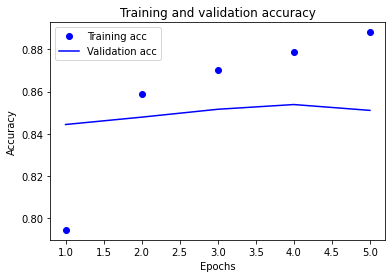

In [30]:
history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [31]:
import os
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(10000-4, 41))  

vectors = model.get_weights()[0]
for i in range(4,10000):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [32]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['진짜']
vector

array([-0.01244265,  0.03822076, -0.00243693,  0.06522395, -0.05674441,
       -0.0094767 ,  0.01058049,  0.03183682, -0.0868463 , -0.01889734,
        0.09385325,  0.04874921, -0.0218068 , -0.06246126, -0.04325496,
       -0.03596998, -0.0430422 , -0.05291134, -0.02468675, -0.07243503,
       -0.01313094, -0.00391529, -0.04188244,  0.04761432, -0.0142893 ,
        0.04251424,  0.03790718,  0.00082239, -0.03341307,  0.0450253 ,
        0.00108229,  0.03330708,  0.00586989,  0.01564533, -0.02573377,
        0.0264744 ,  0.02565298,  0.00800983,  0.00670762,  0.01306644,
       -0.01099802], dtype=float32)

In [33]:
word_vectors.similar_by_word("진짜")

[('예뻐서', 0.7443243265151978),
 ('았었', 0.7104976177215576),
 ('잼', 0.7041564583778381),
 ('..??', 0.6979959607124329),
 ('슬픔', 0.6908084750175476),
 ('메디컬', 0.6884591579437256),
 ('ㅜㅜㅜ', 0.6880357265472412),
 ('기뻤', 0.6866378784179688),
 ('com', 0.6856238842010498),
 ('유치원', 0.681786060333252)]

나쁘지 않은데?

In [34]:
# Kyubyong

import gensim
model = gensim.models.Word2Vec.load('sentiment_classification/ko.bin')

In [35]:
%pwd

'/aiffel/aiffel'

In [36]:
pip install --upgrade gensim

  Using cached gensim-4.3.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.6 MB)
  Attempting uninstall: gensim
    Found existing installation: gensim 3.8.3
    Uninstalling gensim-3.8.3:
      Successfully uninstalled gensim-3.8.3
Note: you may need to restart the kernel to use updated packages.


In [37]:
gensim 버전 호환성 문제 인거같다.. 

SyntaxError: invalid syntax (2287109894.py, line 1)

In [ ]:
pip install --upgrade gensim==3.8.3

In [40]:
# Kyubyong

import gensim
vecmodel = gensim.models.Word2Vec.load('sentiment_classification/ko.bin')

In [41]:
vector = vecmodel['컴퓨터']
print(vector.shape)

(200,)


/tmp/ipykernel_907/649148002.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = vecmodel['컴퓨터']


In [42]:
vecmodel.similar_by_word("사랑")

/tmp/ipykernel_907/4137427437.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  vecmodel.similar_by_word("사랑")


[('슬픔', 0.7216662764549255),
 ('행복', 0.6759077310562134),
 ('절망', 0.6468985080718994),
 ('기쁨', 0.6458414196968079),
 ('이별', 0.6334798336029053),
 ('추억', 0.6320937275886536),
 ('인생', 0.6216273307800293),
 ('애정', 0.6206069588661194),
 ('연인', 0.6186063289642334),
 ('유혹', 0.5965287685394287)]

In [43]:
vecmodel.similar_by_word("진짜")

/tmp/ipykernel_907/2681527375.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  vecmodel.similar_by_word("진짜")


[('가짜', 0.5982679128646851),
 ('정말로', 0.5857688188552856),
 ('바보', 0.5664166212081909),
 ('그저', 0.5368781089782715),
 ('엄마', 0.5301429033279419),
 ('당신', 0.5208492875099182),
 ('강아지', 0.5187654495239258),
 ('프라이빗', 0.5174241065979004),
 ('수수께끼', 0.5051365494728088),
 ('약혼자', 0.504402756690979)]

In [46]:
import numpy as np

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in vecmodel:
        embedding_matrix[i] = vecmodel[index_to_word[i]]
    from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 


model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

/tmp/ipykernel_907/2907448986.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in vecmodel:
/tmp/ipykernel_907/2907448986.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = vecmodel[index_to_word[i]]


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_23 (Dense)             (None, 1)               

In [48]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))   
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

Epoch 1/5
237/237 [==============================] - 2s 8ms/step - loss: 0.5822 - accuracy: 0.6759 - val_loss: 0.4501 - val_accuracy: 0.7938
Epoch 2/5
237/237 [==============================] - 2s 7ms/step - loss: 0.4011 - accuracy: 0.8198 - val_loss: 0.3892 - val_accuracy: 0.8268
Epoch 3/5
237/237 [==============================] - 2s 7ms/step - loss: 0.3358 - accuracy: 0.8558 - val_loss: 0.3606 - val_accuracy: 0.8420
Epoch 4/5
237/237 [==============================] - 2s 7ms/step - loss: 0.3008 - accuracy: 0.8748 - val_loss: 0.3582 - val_accuracy: 0.8458
Epoch 5/5
237/237 [==============================] - 2s 7ms/step - loss: 0.2730 - accuracy: 0.8891 - val_loss: 0.3622 - val_accuracy: 0.8466
1537/1537 - 3s - loss: 0.3678 - accuracy: 0.8445
[0.36776024103164673, 0.8444575667381287]


In [49]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))   
model.add(tf.keras.layers.LSTM(41))   
model.add(tf.keras.layers.Dense(41, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

results = model.evaluate(X_test,  y_test, verbose=2)

print(results)


Epoch 1/5
237/237 [==============================] - 4s 10ms/step - loss: 0.4742 - accuracy: 0.7675 - val_loss: 0.3743 - val_accuracy: 0.8336
Epoch 2/5
237/237 [==============================] - 2s 8ms/step - loss: 0.3416 - accuracy: 0.8518 - val_loss: 0.3554 - val_accuracy: 0.8435
Epoch 3/5
237/237 [==============================] - 2s 8ms/step - loss: 0.2992 - accuracy: 0.8734 - val_loss: 0.3345 - val_accuracy: 0.8557
Epoch 4/5
237/237 [==============================] - 2s 8ms/step - loss: 0.2759 - accuracy: 0.8851 - val_loss: 0.3288 - val_accuracy: 0.8577
Epoch 5/5
237/237 [==============================] - 2s 8ms/step - loss: 0.2530 - accuracy: 0.8960 - val_loss: 0.3353 - val_accuracy: 0.8591
1537/1537 - 3s - loss: 0.3417 - accuracy: 0.8571
[0.34170445799827576, 0.8570905327796936]


85.7% 달성